<a href="https://colab.research.google.com/github/ErfanRasti/HandsOnMachineLearning/blob/master/Chap2Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is related to chapter 2 of the book.

In [1]:
# Importing Libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from zlib import crc32
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tarfile
import urllib.request
import joblib


# Get the Data
## Download the Data

In [2]:

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """
    Fetch the data to the housing_path.

    housing_url -- url of the housing data
    housing_path -- an special path to save the data
    """
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


# Calling the function fetch_housing_data
fetch_housing_data()


In [3]:

# loading the data


def load_housing_data(housing_path=HOUSING_PATH):
    """
    Load the dataset using pandas library.

    Args:
        housing_path ([string]): Defaults to HOUSING_PATH.

    Returns:
        <class 'function'>:
        This function returns a pandas DataFrame object
        containing all the data.
    """
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


In [4]:
housing = load_housing_data()
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Take a Quick Look at the Data Structure

In [5]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()


## Create a Test Set

In [ ]:

def split_train_test(data, test_ratio):
    """
    Split test data from the dataset.

    Args:
        data([DataFrame]): The main dataset
            containing train data and test data

        test_ratio([float]): the ratio of the test data

    Returns:
        train set([DataFrame])
        test set([DataFrame])


    This method randomizes  an indices array with numpy random function.
    The length of array is the same as length of data.
    Then it calculates test set size and splits indices array
    to train indices and test indices.
    Finally it returns the train set and test set.
    """
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


# calling the split_train_test function
train_set, test_set = split_train_test(housing, 0.2)


In [ ]:
len(train_set)


16512

In [ ]:
len(test_set)


4128

In [ ]:

def test_set_check(identifier, test_ratio):
    """Check the identifier with maximum hash value."""
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32


In [ ]:

def split_train_test_by_id(data, test_ratio, id_column):
    """Split the data by id_column."""
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


In [ ]:

housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")


In [ ]:

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")


In [ ]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


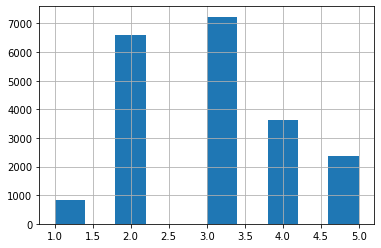

In [ ]:

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()


In [ ]:

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# using "income_cat" attribute to split the train and test set
for train_index, test_index in split.split(housing, housing["income_cat"]):
    """
    We mention the target variable in the second argument of split function,
    to split the data according to this variable.
    """
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)


3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [ ]:
# removing the redundant attribute
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


# Discover and Visualize the Data to Gain Insights
## Visualizing Geographical Data

In [ ]:
# replacing the housing variable with stratified train set
housing = strat_train_set.copy()


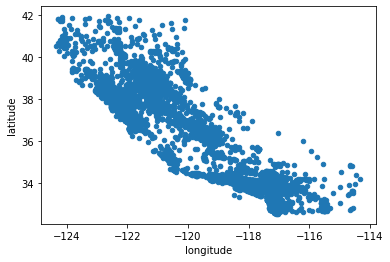

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude")


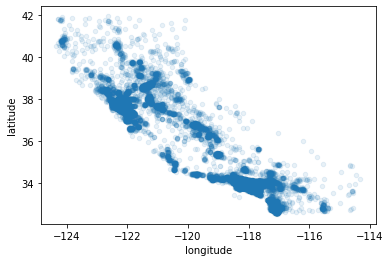

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)


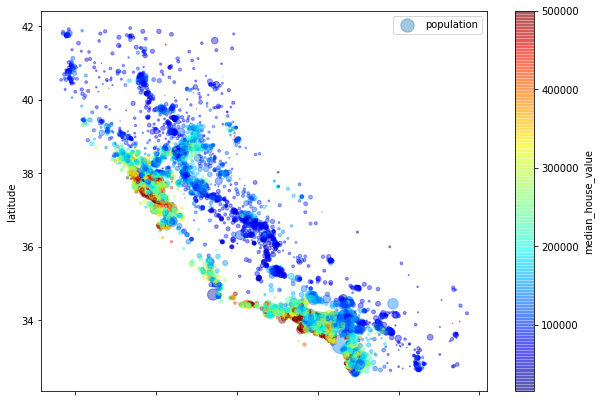

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             )
plt.legend()


## Looking for Correlations

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f30b7be6f90>,
      dtype=object)

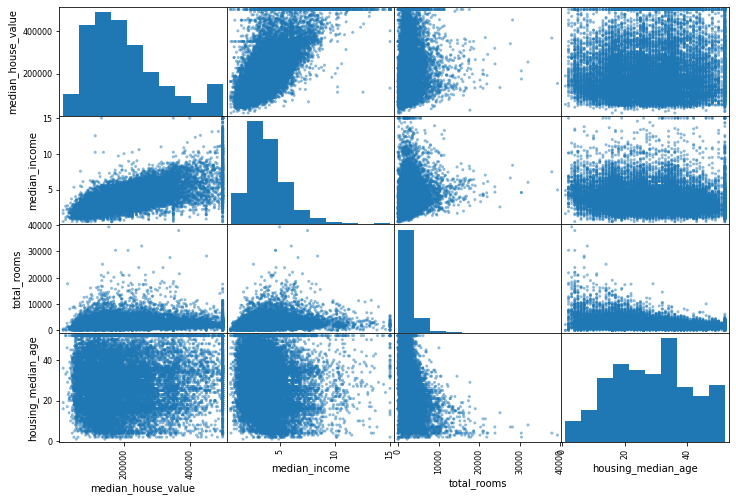

In [ ]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))


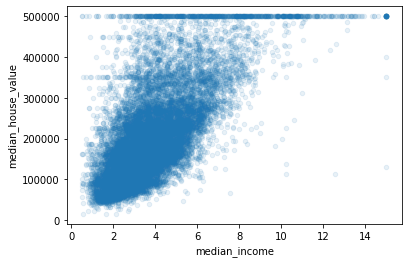

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)


## Experimenting with Attribute Combinations

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"] / \
    housing["households"]


In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


## Data Cleaning

In [ ]:
housing.dropna(subset=["total_bedrooms"])  # option 1
housing.drop("total_bedrooms", axis=1)  # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)


In [ ]:
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)


SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [ ]:
imputer.statistics_, housing_num.median().values


(array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
         408.    ,    3.5409]),
 array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
         408.    ,    3.5409]))

In [ ]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)


## Handling Text and Categorical Attributes

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)


,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [ ]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]


array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [ ]:
ordinal_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
housing_cat_1hot.toarray()


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
cat_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers

In [ ]:

# Index Location
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """This class adds some extra attributes to the dataset."""

    """
    BaseEstimator: Base class for all estimators in scikit-learn.
    TransformerMixin: Mixin class for all transformers in scikit-learn.
    """

    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        """Initialize the add_bedrooms_per_room parameter, to determine\
        if this column adds or not."""
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        """Return the dataset itself."""
        return self  # nothing else to do

    def transform(self, X):
        """Transform the dataset with adding some new attributes."""
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            """
            numpy.c_ :
            Translates slice objects to concatenation along the second axis.
            """
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


# Defining the object
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
# Applying the object on the housing.values and saving it in a new variable
housing_extra_attribs = attr_adder.transform(housing.values)


## Feature Scaling
## Transformation Pipelines

In [ ]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)


In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)


# Select and Train a Model
## Training and Evaluating on the Training Set

In [ ]:
housing_prepared, housing_labels


(array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
          0.        ,  0.        ],
        [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
          0.        ,  0.        ],
        [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
          1.        ,  0.        ]]), 17606    286600.0
 18632    340600.0
 14650    196900.0
 3230      46300.0
 3555     254500.0
            ...   
 6563     240200.0
 12053    113000.0
 13908     97800.0
 11159    225900.0
 15775    500001.0
 Name: median_house_value, Length: 16512, dtype: float64)

In [ ]:
cachePath = os.path.join("cache", "Chap2")
os.makedirs(cachePath,exist_ok=True)

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

if os.path.isfile("cache/Chap2/lin_reg.pkl"):
    # loading the model
    lin_reg = joblib.load("cache/Chap2/lin_reg.pkl")

else:
    lin_reg.fit(housing_prepared, housing_labels)

    # saving the model
    joblib.dump(lin_reg, "cache/Chap2/lin_reg.pkl")


In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))


Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [ ]:
print("Labels:", list(some_labels))


Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse


68628.19819848923

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()

if os.path.isfile("cache/Chap2/tree_reg.pkl"):
    # loading the model
    tree_reg = joblib.load("cache/Chap2/tree_reg.pkl")

else:
    tree_reg.fit(housing_prepared, housing_labels)

    # saving the model
    joblib.dump(tree_reg, "cache/Chap2/tree_reg.pkl")


In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse


0.0

## Better Evaluation Using Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score


if os.path.isfile("cache/Chap2/tree_scores.pkl"):
    # loading the model
    tree_scores = joblib.load("cache/Chap2/tree_scores.pkl")

else:
    tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                                  scoring="neg_mean_squared_error", cv=10)

    # saving the model
    joblib.dump(tree_scores, "cache/Chap2/tree_scores.pkl")


tree_rmse_scores = np.sqrt(-tree_scores)


In [ ]:
def display_scores(scores):
    """Display the scores."""
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


display_scores(tree_rmse_scores)


Scores: [70541.4240873  64524.10583041 70562.20460784 68810.98886905
 70444.08528894 73764.89146444 71111.49053628 72600.73859808
 75733.20032707 69736.59882319]
Mean: 70782.97284326071
Standard deviation: 2849.3464492321


In [ ]:

if os.path.isfile("cache/Chap2/lin_scores.pkl"):
    # loading the model
    lin_scores = joblib.load("cache/Chap2/lin_scores.pkl")

else:
    lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                                 scoring="neg_mean_squared_error", cv=10)

    # saving the model
    joblib.dump(lin_scores, "cache/Chap2/lin_scores.pkl")

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()

if os.path.isfile("cache/Chap2/forest_reg.pkl"):
    # loading the model
    forest_reg = joblib.load("cache/Chap2/forest_reg.pkl")


else:
    forest_reg.fit(housing_prepared, housing_labels)

    # saving the model
    joblib.dump(forest_reg, "cache/Chap2/forest_reg.pkl")

housing_predictions = forest_reg.predict(housing_prepared)

In [ ]:

forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse


18745.173716502923

In [ ]:
if os.path.isfile("cache/Chap2/forest_scores.pkl"):
    # loading the model
    forest_scores = joblib.load("cache/Chap2/forest_scores.pkl")

else:
    forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                    scoring="neg_mean_squared_error", cv=10)

    # savinge the model
    joblib.dump(forest_scores, "cache/Chap2/forest_scores.pkl")


forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)


Scores: [49494.88142851 47556.7930095  49762.69348734 52403.19454506
 49664.06110443 53273.00498657 48591.57725845 47984.62506177
 52716.02754883 50334.19273373]
Mean: 50178.105116419916
Standard deviation: 1899.9512367588734


# Fine-Tune Your Model
## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

if os.path.isfile("cache/Chap2/grid_search.pkl"):
    # loading the model
    grid_search = joblib.load("cache/Chap2/grid_search.pkl")

else:
    grid_search.fit(housing_prepared, housing_labels)

    # saving the model
    joblib.dump(grid_search, "cache/Chap2/grid_search.pkl")


In [ ]:
grid_search.best_params_


{'max_features': 8, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


63838.56311440001 {'max_features': 2, 'n_estimators': 3}
55753.545330869616 {'max_features': 2, 'n_estimators': 10}
52514.520591401044 {'max_features': 2, 'n_estimators': 30}
61020.542427536515 {'max_features': 4, 'n_estimators': 3}
52492.480484598935 {'max_features': 4, 'n_estimators': 10}
50464.34699165217 {'max_features': 4, 'n_estimators': 30}
60109.76530422424 {'max_features': 6, 'n_estimators': 3}
52215.11355255469 {'max_features': 6, 'n_estimators': 10}
50041.65254575007 {'max_features': 6, 'n_estimators': 30}
58475.41281649266 {'max_features': 8, 'n_estimators': 3}
52211.90146094614 {'max_features': 8, 'n_estimators': 10}
49918.076799283255 {'max_features': 8, 'n_estimators': 30}
63086.72466714553 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54818.36872983441 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59428.70299679807 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52172.513550897056 {'bootstrap': False, 'max_features': 3, 'n_estimator

## Randomized Search
## Ensemble Methods
## Analyze the Best Models and Their Errors

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.14129166e-02, 6.56237882e-02, 4.21332849e-02, 1.64715852e-02,
       1.43199162e-02, 1.48304423e-02, 1.40645734e-02, 3.61609050e-01,
       5.03747662e-02, 1.11606520e-01, 5.98531486e-02, 3.32329460e-03,
       1.68788291e-01, 8.98232953e-05, 2.23557243e-03, 3.26302698e-03])

In [ ]:
# hhold: household
# pop: population
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
full_pipeline


ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='median',
                                                                verbose=0)),
                                                 ('attribs_adder',
                                                  CombinedAttributesAdder(add_bedrooms_per_room=True)),
                                                 ('std_scaler',
         

In [ ]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_encoder


OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [ ]:
cat_one_hot_attribs = list(cat_encoder.categories_[0])
cat_one_hot_attribs


['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

In [ ]:
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
attributes


['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)


[(0.36160905021657314, 'median_income'),
 (0.16878829089523917, 'INLAND'),
 (0.11160651991049844, 'pop_per_hhold'),
 (0.07141291660855845, 'longitude'),
 (0.06562378817608953, 'latitude'),
 (0.0598531486095242, 'bedrooms_per_room'),
 (0.050374766245216585, 'rooms_per_hhold'),
 (0.0421332848788912, 'housing_median_age'),
 (0.01647158522682009, 'total_rooms'),
 (0.014830442306970192, 'population'),
 (0.014319916168550774, 'total_bedrooms'),
 (0.014064573441702791, 'households'),
 (0.0033232946021621653, '<1H OCEAN'),
 (0.003263026984810901, 'NEAR OCEAN'),
 (0.00223557243310603, 'NEAR BAY'),
 (8.982329528644426e-05, 'ISLAND')]

## Evaluate Your System on the Test Set

In [ ]:
final_model = grid_search.best_estimator_
final_model


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)


In [ ]:
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)

# RMSE: Root Mean Square Error
final_rmse = np.sqrt(final_mse)  # => evaluates to 47,730.2
final_rmse


47222.23152088174

In [ ]:
# calculating confidence interval
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
"""
df: degree of freedom

scipy.stats.t.interval: Endpoints of the range that contains fraction alpha [0, 1] of the distribution

squared_errors.mean(): mean_squared_error(y_test, final_predictions)

scipy.stats.sem: Calculate the standard error of the mean
                (or standard error of measurement) of the values in the input array.
"""

np.sqrt(stats.t.interval(confidence,
                         len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))


array([45307.13309222, 49062.63334339])

In [ ]:

acc = final_model.score(X_test_prepared, y_test)
acc


0.8288827239633756

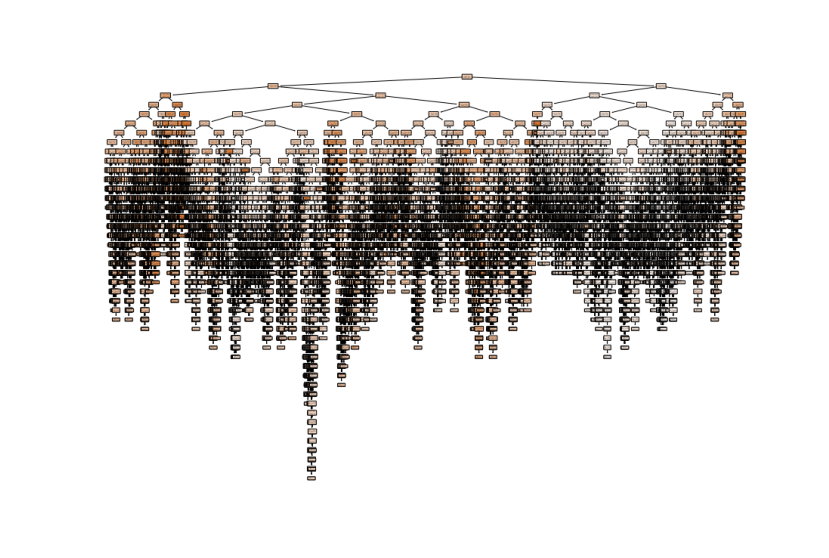

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))

figuresPath = os.path.join("figures", "Chap2")
os.makedirs(figuresPath, exist_ok=True)

if os.path.isfile("figures/Chap2/final_model_estimators_0.png"):
  # Reading the image
  
  img = mpimg.imread("figures/Chap2/final_model_estimators_0.png")
  plt.imshow(img)
  plt.axis('off')
else:
  plot_tree(final_model.estimators_[0], 
            filled=True, impurity=True, 
            rounded=True)
  
  # Saving the image
  fig.savefig("figures/Chap2/final_model_estimators_0.png")
  

# Exercises


## Ex1

In [ ]:
from sklearn.svm import SVR


param_grid_SVR = [
    {'kernel': ['linear'], 'C': [30000.0, 100000.0, 300000.0]},
    {'kernel': ['rbf'], 'C': [100.0, 300.0, 1000.0],
     'gamma': [0.1, 0.3, 1.0]},
]

svm_reg = SVR()

"""
verbose: int
    Controls the verbosity: the higher, the more messages.
"""
grid_search_SVR = GridSearchCV(svm_reg,
                               param_grid_SVR,
                               cv=5,
                               scoring='neg_mean_squared_error',
                               verbose=2,
                               n_jobs=-1,
                               return_train_score=True)

if os.path.isfile("cache/Chap2/grid_search_SVR.pkl"):
    # loading the model
    grid_search_SVR = joblib.load("cache/Chap2/grid_search_SVR.pkl")

else:
    grid_search_SVR.fit(housing_prepared, housing_labels)

    # saving the model
    joblib.dump(grid_search_SVR, "cache/Chap2/grid_search_SVR.pkl")


In [ ]:
negative_mse = grid_search_SVR.best_score_
rmse = np.sqrt(-negative_mse)
rmse


70352.55299120622

In [ ]:
grid_search_SVR.best_params_


{'C': 100000.0, 'kernel': 'linear'}

## Ex2

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, loguniform

"""
ee https://docs.scipy.org/doc/scipy/reference/stats.html
for `expon()` and `reciprocal()` documentation and more probability distribution functions.
`loguniform()` acts like `reciprocal()`.
"""
# Note: gamma is ignored when kernel is "linear"

param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': loguniform(20, 200000),
    'gamma': expon(scale=1.0),
}

svm_reg = SVR()
rnd_search_SVR = RandomizedSearchCV(svm_reg,
                                    param_distributions=param_distribs,
                                    n_iter=10,
                                    cv=5,
                                    scoring='neg_mean_squared_error',
                                    verbose=2,
                                    random_state=42,
                                    n_jobs=-1)


if os.path.isfile("cache/Chap2/rnd_search_SVR.pkl"):
    # loading the model
    rnd_search_SVR = joblib.load("cache/Chap2/rnd_search_SVR.pkl")

else:
    rnd_search_SVR.fit(housing_prepared, housing_labels)

    # saving the model
    joblib.dump(rnd_search_SVR, "cache/Chap2/rnd_search_SVR.pkl")


In [ ]:
negative_mse = rnd_search_SVR.best_score_
rmse = np.sqrt(-negative_mse)
rmse


54767.960710084146

In [ ]:
rnd_search_SVR.best_params_


{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

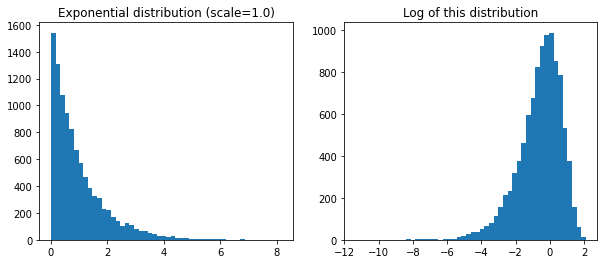

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()


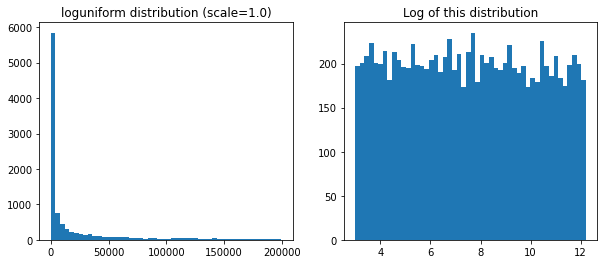

In [ ]:
# reciprocal.pdf(x, a, b) = 1 / (x*log(b/a))
loguniform_distrib = loguniform(20, 200000)

"""
rvs(a, b, loc=0, scale=1, size=1, random_state=None)

    Random variates.
"""
samples = loguniform_distrib.rvs(10000, random_state=42)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("loguniform distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()


The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## Ex3

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


def indices_of_top_k(arr, k):
    """Return the indices of the top k values."""
    return np.sort(np.argsort(np.array(arr))[-k:])
# def indices_of_top_k(arr, k):
#     return np.sort(np.argpartition(np.array(arr), -k)[-k:])


class TopFeatureSelector(BaseEstimator, TransformerMixin):
    """This class adds feature indices of top k values to the fitted data."""
    def __init__(self, feature_importances, k):
        """Initialize the class with feature_importance and k value."""
        self.feature_importances = feature_importances
        self.k = k

    def fit(self, X, y=None):
        """Add feature_indices_ attribute to the fitted data."""
        # self.feature_indices_: indices of top k values
        self.feature_indices_ = indices_of_top_k(
            self.feature_importances, self.k)
        return self

    def transform(self, X):
        """Return the feature_indices_ column."""
        return X[:, self.feature_indices_]


In [ ]:
feature_importances

array([7.14129166e-02, 6.56237882e-02, 4.21332849e-02, 1.64715852e-02,
       1.43199162e-02, 1.48304423e-02, 1.40645734e-02, 3.61609050e-01,
       5.03747662e-02, 1.11606520e-01, 5.98531486e-02, 3.32329460e-03,
       1.68788291e-01, 8.98232953e-05, 2.23557243e-03, 3.26302698e-03])

In [ ]:
k = 5
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices


array([ 0,  1,  7,  9, 12])

In [ ]:
attributes

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [ ]:
np.array(attributes)[top_k_feature_indices]


array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]


[(0.36160905021657314, 'median_income'),
 (0.16878829089523917, 'INLAND'),
 (0.11160651991049844, 'pop_per_hhold'),
 (0.07141291660855845, 'longitude'),
 (0.06562378817608953, 'latitude')]

In [ ]:
full_pipeline, TopFeatureSelector(feature_importances, k)

(ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('num',
                                  Pipeline(memory=None,
                                           steps=[('imputer',
                                                   SimpleImputer(add_indicator=False,
                                                                 copy=True,
                                                                 fill_value=None,
                                                                 missing_values=nan,
                                                                 strategy='median',
                                                                 verbose=0)),
                                                  ('attribs_adder',
                                                   CombinedAttributesAdder(add_bedrooms_per_room=True)),
                                                  ('std_scal

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])


In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(
    housing)
housing_prepared_top_k_features


array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ],
       ...,
       [ 1.58648943, -0.72478134, -0.3167053 , -0.03055414,  1.        ],
       [ 0.78221312, -0.85106801,  0.09812139,  0.06150916,  0.        ],
       [-1.43579109,  0.99645926, -0.15779865, -0.09586294,  0.        ]])

In [ ]:
housing_prepared[0:3]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ]])

In [ ]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

## Ex4

In [ ]:

param_distribs_forest = {
    'n_estimators': np.arange(start=10, stop=500, step=10),
    'max_features': np.arange(start=1, stop=6, step=1),
}

forest_reg = RandomForestRegressor()

rnd_search_forest = RandomizedSearchCV(forest_reg,
                                       cv=5,
                                       param_distributions=param_distribs_forest,
                                       n_iter=10,
                                       verbose=2,
                                       n_jobs=-1,
                                       scoring='neg_mean_squared_error',
                                       return_train_score=True)

if os.path.isfile("cache/Chap2/rnd_search_forest.pkl"):
    # loading the model
    rnd_search_forest = joblib.load("cache/Chap2/rnd_search_forest.pkl")

else:
  rnd_search_forest.fit(housing_prepared_top_k_features, housing_labels)

  # saving the model
  joblib.dump(rnd_search_forest, "cache/Chap2/rnd_search_forest.pkl")


In [ ]:
rnd_search_forest.best_params_

{'max_features': 1, 'n_estimators': 190}

In [ ]:
cvres_forest = rnd_search_forest.cv_results_
for mean_score, params in zip(cvres_forest["mean_test_score"], cvres_forest["params"]):
    print(np.sqrt(-mean_score), params)

52070.168679666145 {'n_estimators': 10, 'max_features': 2}
51175.695561837645 {'n_estimators': 190, 'max_features': 5}
49937.59884173991 {'n_estimators': 310, 'max_features': 3}
51102.48004619391 {'n_estimators': 450, 'max_features': 5}
48613.160473525924 {'n_estimators': 100, 'max_features': 1}
48539.104069759036 {'n_estimators': 190, 'max_features': 1}
49896.56130431974 {'n_estimators': 200, 'max_features': 3}
49029.12729118283 {'n_estimators': 60, 'max_features': 1}
51206.73195698988 {'n_estimators': 180, 'max_features': 5}
49298.738054771384 {'n_estimators': 440, 'max_features': 2}


In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('forest_reg', RandomForestRegressor(**rnd_search_forest.best_params_))
])


if os.path.isfile("cache/Chap2/prepare_select_and_predict_pipeline.pkl"):
    # loading the model
    prepare_select_and_predict_pipeline = joblib.load("cache/Chap2/prepare_select_and_predict_pipeline.pkl")

else:
  prepare_select_and_predict_pipeline.fit(housing, housing_labels)

  # saving the model
  joblib.dump(prepare_select_and_predict_pipeline, "cache/Chap2/prepare_select_and_predict_pipeline.pkl")



In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [265347.89473684 338302.11578947 203017.36842105  49352.63157895]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

prediction_rnd_forest_full_pipeline = prepare_select_and_predict_pipeline.predict(X_test)

final_mse = mean_squared_error(y_test, prediction_rnd_forest_full_pipeline)
final_rmse = np.sqrt(final_mse)
final_rmse

46655.28346500541

## Ex5

In [ ]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline,
                                param_grid,
                                cv=5,
                                scoring='neg_mean_squared_error',
                                verbose=2)



if os.path.isfile("cache/Chap2/grid_search_prep.pkl"):
    # loading the model
    grid_search_prep = joblib.load("cache/Chap2/grid_search_prep.pkl")

else:
  grid_search_prep.fit(housing, housing_labels)

  # saving the model
  joblib.dump(grid_search_prep, "cache/Chap2/grid_search_prep.pkl")



In [ ]:
grid_search_prep.best_params_

{'feature_selection__k': 5,
 'preparation__num__imputer__strategy': 'most_frequent'}

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", grid_search_prep.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [267676.32105263 339818.96315789 202750.52631579  48598.94736842]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

prediction_grid_search_prep = grid_search_prep.predict(X_test)

final_mse = mean_squared_error(y_test, prediction_grid_search_prep)
final_rmse = np.sqrt(final_mse)
final_rmse

46345.085006066925

In [ ]:
grid_search_prep.best_estimator_

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='most_frequent',
                                                       